# UE22CS342AA2: Data Analytics - Worksheet 3a
# Time Series Analysis and Forecasting Techniques

Designed by Anshul Ranjan, Dept.of CSE - itsanshulranjan@gmail.com

## Student Details

• Name: NEHA NAIR

• SRN: PES2UG22CS348

• Section: F

## Air Passengers Analysis
Imagine you're optimizing airline services. \
You've been given a dataset, your task is to analyze monthly trends in air passenger numbers to inform decisions such as route planning, pricing strategies, and enhancing the overall travel experience.

### Contents of the worksheet

It is suggested to have a grip on the theoretical concepts of:

* Components of time series data 
* Decomposition of time series data
* Exponential Smoothing techniques
* Stationary Signals, Dickey-fuller test and Differencing
* Forecasting with AR, MA, ARMA
* Autocorrelation (ACF, PACF) and ARIMA
* Seasonality in Time Series and SARIMA

### Dataset

The data is provided in the AirPassengers.csv file. The data dictionary is as follows:

* Month: The month of the year (formatted as 'YYYY-MM') during which passenger data was collected.
* Passengers: The number of air passengers recorded during that month.

The target variable is **Passengers**, which we shall analyze and forecast in this worksheet. Understanding the trends and patterns in air passenger data is crucial for airline route planning, pricing strategies, capacity management, and enhancing the overall travel experience. Accurately predicting passenger volumes aids in optimizing resources, scheduling, and making informed decisions to meet market demands and improve service quality.

In [106]:
# Load necessary libraries
library(dplyr) 
library(tidyr)  
library(ggplot2) 

options(warn=-1)

### Data Ingestion and Preprocessing
• Reading this file into a data.frame object

In [107]:
# Read the CSV file
df <- read.csv('/kaggle/input/flight-attendees/AirPassengers.csv')

# Display information about the data frame
str(df)

'data.frame':	144 obs. of  2 variables:
 $ Month       : chr  "1949-01" "1949-02" "1949-03" "1949-04" ...
 $ X.Passengers: int  112 118 132 129 121 135 148 148 136 119 ...


In [108]:
head(df)

,Month,X.Passengers
,<chr>,<int>
1,1949-01,112
2,1949-02,118
3,1949-03,132
4,1949-04,129
5,1949-05,121
6,1949-06,135


The class (data type) of each column in the data frame

In [109]:
sapply(df, class)

Month X.Passengers 
 "character"    "integer"

In [110]:
# Convert 'Month' to Date type
df$Month <- as.Date(paste0(df$Month, "-01"), format="%Y-%m-%d")

# Check the data types of the columns
sapply(df, class)

Month X.Passengers 
      "Date"    "integer"

In [111]:
length(unique(df$Month))

[1] 144

In [112]:
# Rename columns
df <- df %>% rename(value = X.Passengers, month = Month)
head(df)

,month,value
,<date>,<int>
1,1949-01-01,112
2,1949-02-01,118
3,1949-03-01,132
4,1949-04-01,129
5,1949-05-01,121
6,1949-06-01,135


Setting the 'Month' column as the index of the DataFrame to organize the data by time, then plotting the data to visualize the trend in passenger numbers over the given months.

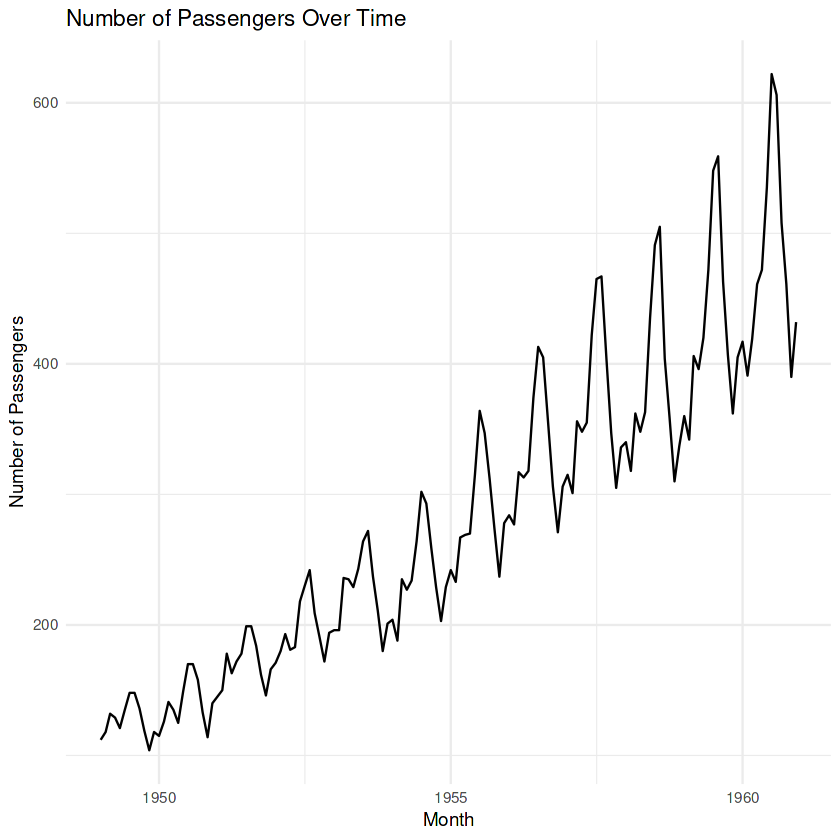

In [113]:
# Set 'month' as the index (not strictly necessary in R but useful for plotting)
df <- df %>% arrange(month)

# Plot the data
ggplot(df, aes(x = month, y = value)) +
  geom_line() +
  labs(title = "Number of Passengers Over Time", x = "Month", y = "Number of Passengers") +
  theme_minimal()

Applying a 12-month rolling average to the 'value' column to smooth out short-term fluctuations and highlight longer-term trends, then plotting this smoothed data with 'Date' as the x-axis label for better visualization.

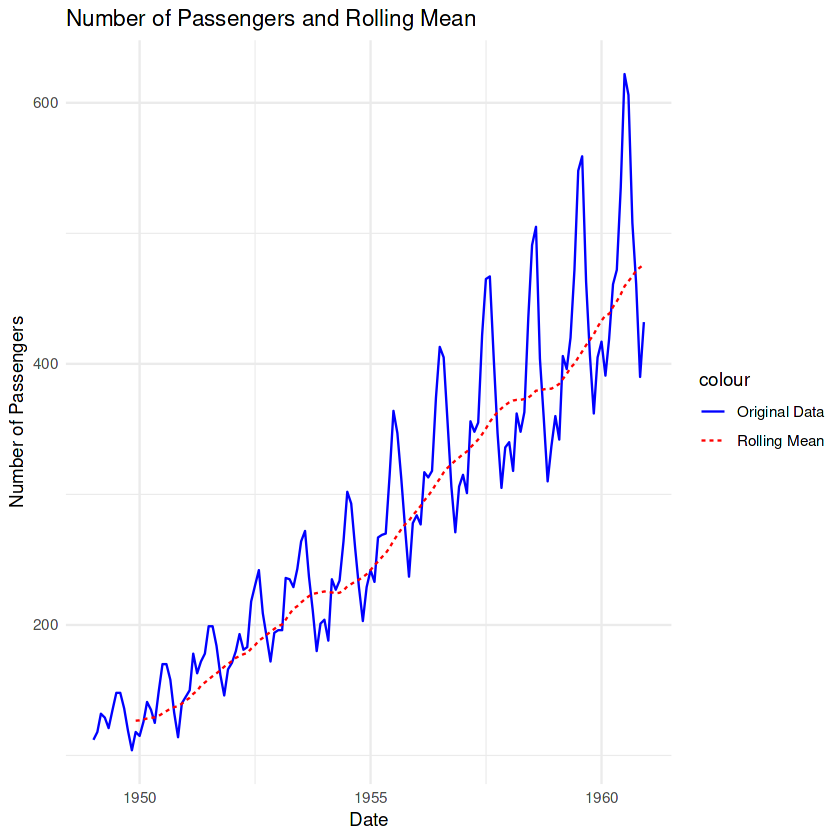

In [114]:
#library(zoo)
# Calculate the rolling mean
df$rolling_mean <- rollmean(df$value, k = 12, fill = NA, align = "right")

# Plot the rolling mean
ggplot(df, aes(x = month)) +
  geom_line(aes(y = value, color = "Original Data")) +
  geom_line(aes(y = rolling_mean, color = "Rolling Mean"), linetype = "dashed") +
  labs(title = "Number of Passengers and Rolling Mean",
       x = "Date",
       y = "Number of Passengers") +
  theme_minimal() +
  scale_color_manual(values = c("Original Data" = "blue", "Rolling Mean" = "red"))


## Stationarity
• Testing for stationarity \
– We can use the Augmented Dickey-Fuller test (ADF) to test the time series for stationarity

Question 3.1: What are the null hypothesis and alternate hypothesis in this case?

In [115]:
# Your answer here
library(tseries)
adf.test(df$month)


	Augmented Dickey-Fuller Test

data:  df$month
Dickey-Fuller = -7.7118, Lag order = 5, p-value = 0.01
alternative hypothesis: stationary


Null Hypothesis: The time series has a unit root. it is non-stationary.

Alternative Hypothesis: The time series does not have a unit root. it is stationary.

Question 3.2: What are you doing by performing the Augmented Dickey-Fuller (ADF) test on the 'value' column, and how do you interpret the ADF statistic and p-value to determine if the data is stationary?

In [116]:
#Your answer here

By performing the Augmented Dickey-Fuller (ADF) test on the 'value' column, we are checking if the time series data in that column is stationary or non-stationary.

The ADF statistic is -7.7118: strongly negative value implies that the time series is stationary.

p-value is 0.01. p-value is less than the chosen significance level (0.05). Therefore, reject the null hypothesis. The series is stationary.


Question 3.3: Write the code to perform the Augmented Dickey-Fuller (ADF) test on the 'value' column of the DataFrame df to check for stationarity. After running the code, determine whether the data is stationary based on the p-value.

 > Hint : Check the tseries library to perform the test (adf function)
 > * Don't Forget to perform this y <- diffinv(x) before the adf test check the docs here - https://cran.r-project.org/web/packages/tseries/tseries.pdf
 > * https://uribo.github.io/rpkg_showcase/date_and_time/tseries.html
 > * https://rdrr.io/cran/tseries/

In [117]:
# Your answer here
library(tseries)
y <-diffinv(df$value)
result <-adf.test(y)
print(result)


	Augmented Dickey-Fuller Test

data:  y
Dickey-Fuller = 2.6449, Lag order = 5, p-value = 0.99
alternative hypothesis: stationary



p-value(0.99)is greater than the significance value(0.05).
We accept the null hypothesis.
Value column in time series is NOT stationary.

• If the data is not stationary, and if we intend to use a model like ARIMA, the data has to
be transformed. \
• Two most common methods to transform series to stationary are:

* Transformations: eg. log or square root or combinations of these transformations to
stabilize non-constant variance.
* Differencing: subtract current value from previous (with a certain degree)

Check this out for more information, and an implementation in Python!: \
https://www.kaggle.com/code/rdizzl3/time-series-transformations

Question 3.4: Create a new dataframe using suitable differencing order, to convert the data
to stationary time series. 
 > Hint: You can use the same function to confirm the time series is stationary after transformation.

Try to perform first order differencing and observe how the values changes (ADF statistic and p-value), also observe the change in ACF and PACF plots \
Always try to plot the graphs before making the final decision


	Augmented Dickey-Fuller Test

data:  na.omit(df$diff_value)
Dickey-Fuller = -7.0177, Lag order = 5, p-value = 0.01
alternative hypothesis: stationary



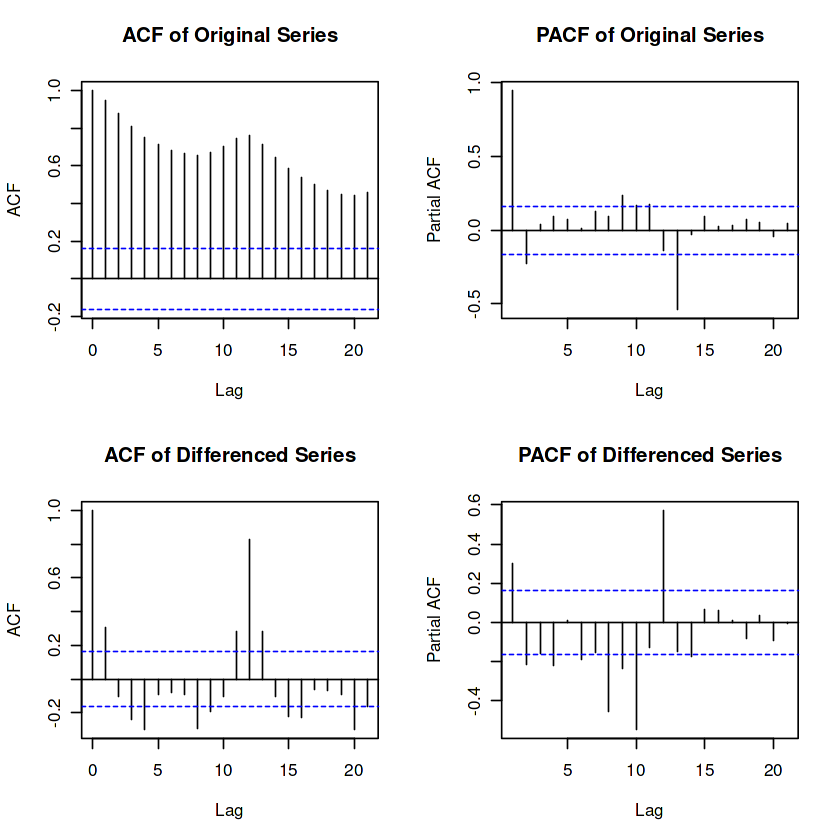

In [118]:
# Your answer here
df$diff_value <- c(NA, diff(df$value, differences = 1)) 
adf_test_diff <- adf.test(na.omit(df$diff_value), k=5)
print(adf_test_diff)
par(mfrow = c(2, 2)) 
acf(df$value, main="ACF of Original Series")
pacf(df$value, main = "PACF of Original Series")
acf(na.omit(df$diff_value), main = "ACF of Differenced Series")
pacf(na.omit(df$diff_value), main = "PACF of Differenced Series")

## Autocorrelation Analysis
• We will experiment and plot two functions: 
* **ACF (Autocorrelation function)**: The autocorrelation function (ACF) is a statistical technique that we can use to identify how correlated the values in a time series are with each other. The ACF plots the correlation coefficient against the lag, which is measured in terms of a number
of periods or units.
* **PACF (Partial Autocorrelation function)**: Partial autocorrelation is a statistical measure that captures the correlation between two variables after controlling for the effects of other variables.

In [119]:
library(stats)

# Compute and plot ACF
#acf_result <- acf(example, lag.max = 50, main = "ACF of Differenced Data")

# Compute and plot PACF
#pacf_result <- pacf(example, lag.max = 50, main = "PACF of Differenced Data")

Question 3.5 : What are the values of p, q and d? How did you come to this conclusion,
looking at the ACF, PACF plots? \
> Hint: The value of d is decided by the order of differencing, as transformed in the previous
section.

#### Your answer here:
Based on the ACF and PACF plots:

p(AR order)= 1 (based on the first spike in the PACF of the differenced series)
d(Differencing order)=1 (based on the need for first-order differencing)
q(MA order)=1 (based on the first spike in the ACF of the differenced series)
Thus, an appropriate model could be ARIMA(1, 1, 1).

## Decomposition

Question 3.6: 
1. Decompose the **value** column into the constituent components, and plot them. 
2. Which model of time series did you use for decomposition, and why? (between additive and multiplicative models)

> Hint: The data is Sesonal, Look at the decompose function in stats library.

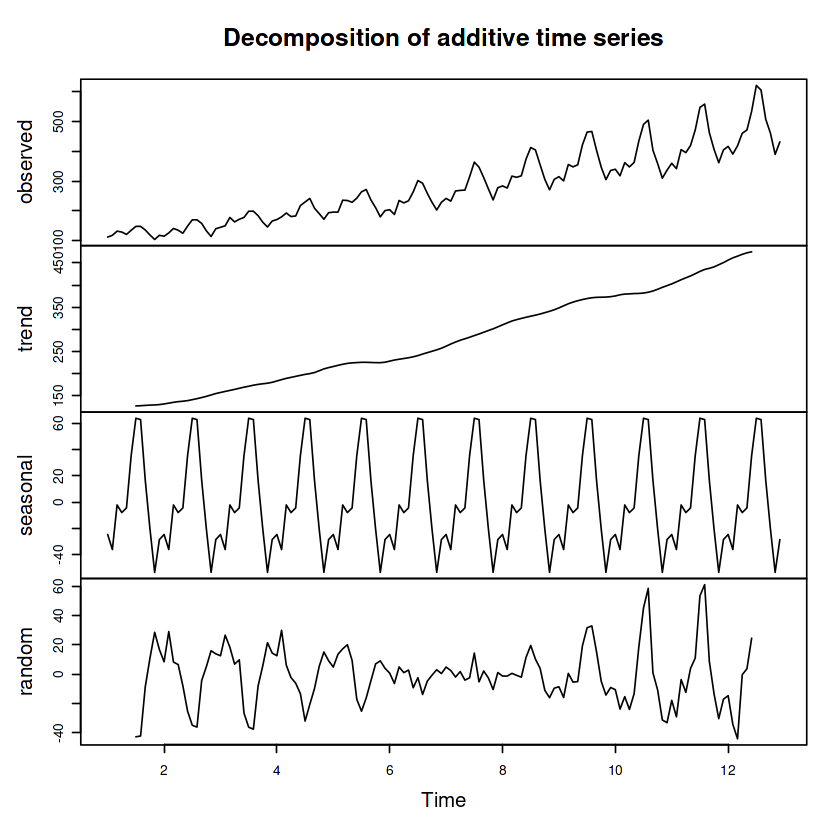

In [120]:
ts_data <- ts(df$value, frequency = 12)
decomposed_data <- decompose(ts_data, type = "additive")
plot(decomposed_data)

#### the seasonal component is constant over time hence we use additive time series

Note: Sometimes, we look at upsampling or downsampling the data. For instance, if we
have sensor data for each second, we might not need such granular data, and we
downsample the data to daily data or hourly data or so.
Explore further here: https://machinelearningmastery.com/resample-interpolatetime-series-data-python/

You can also explore adding the decomposed versions of each feature (column) to your data, and utilize it
as exogenous variables for multivariate forecasting! This would require you to decompose all features, such
as temperature, rainfall, etc. as well, which is out of scope of this worksheet.

## Exponential Smoothing

Question 3.7:

• Perform forecasts using Single, Double and Triple Exponential Smoothing. \
• Plot forecasts of all three forecasts (using different colors), against the true values. (Use lines) \
• Only one function needed for all three forecasts, only requiring you to change the parameters to get each of the 3 models. \
• Hint: look at the ExponentialSmoothing function \
• Go ahead, and experiment with the values of alpha, beta and gamma and see how the forecast changes.

> Hint: Use the forecast library

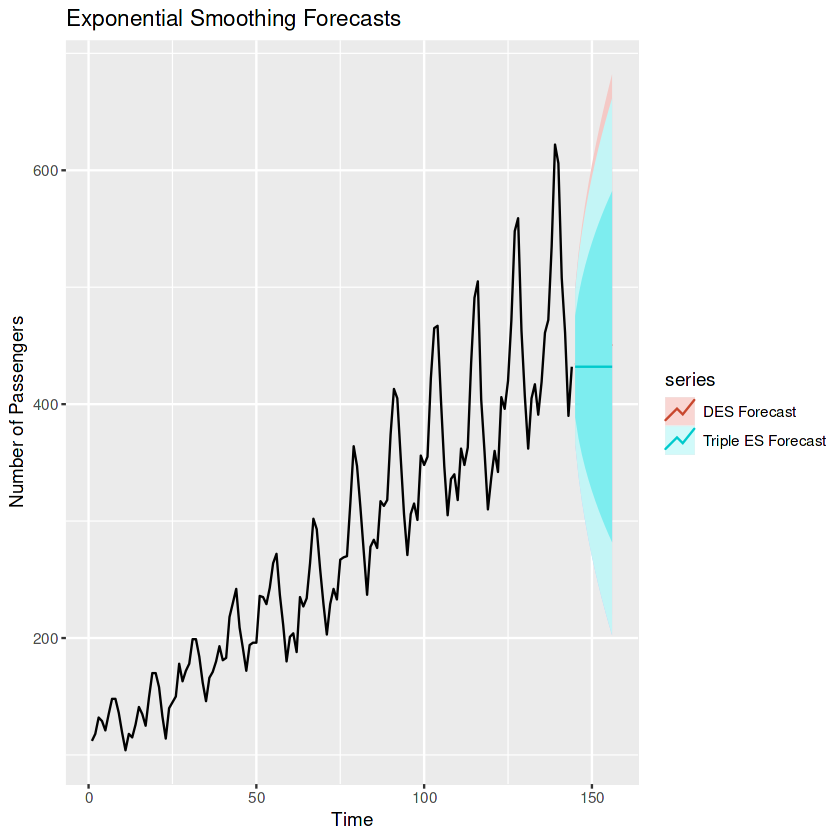

In [121]:
# Your answer here
library(forecast)

#Single
ses_model <- ets(df$value, model="ANN")
ses_forecast <- forecast(ses_model, h=12)

#double
holt_model <- ets(df$value, model="AAN")
holt_forecast <- forecast(holt_model, h=12)

#triple
hw_model <- ets(df$value, model="ANN")
hw_forecast <- forecast(hw_model, h=12)

autoplot(ses_forecast, series="SES Forecast") + autolayer(holt_forecast, series="DES Forecast") +  autolayer(hw_forecast, series="Triple ES Forecast") +  ggtitle("Exponential Smoothing Forecasts") +  ylab("Number of Passengers")

In [122]:
library(Metrics)

# Define the function to calculate metrics
calculate_metrics <- function(actual_values, predicted_values) {
  mae_value <- mae(actual_values, predicted_values)
  mse_value <- mse(actual_values, predicted_values)
  rmse_value <- rmse(actual_values, predicted_values)
  mape_value <- mean(abs((actual_values - predicted_values) / actual_values)) * 100
  
  return(list(MAE = mae_value, MAPE = mape_value, MSE = mse_value, RMSE = rmse_value))
}

# Generate some example data and forecasts (replace with your actual data and forecasts)
# For demonstration purposes, assuming `df` contains the actual values and the forecasts are for the next 12 periods
forecast_periods <- 12
actual_values <- tail(df$value, forecast_periods)


# forecast_single <- as.numeric(forecast(sample_df, h = forecast_periods)$mean)
# forecast_double <- as.numeric(forecast(sample_df, h = forecast_periods)$mean)
# forecast_triple <- as.numeric(forecast(sample_df, h = forecast_periods)$mean)

Question 3.8: Compare accuracy metrics (MAE, MAPE, MSE, RMSE) of the three models with the original series.

In [123]:
library(Metrics)

# Define the function to calculate metrics
calculate_metrics <- function(actual_values, predicted_values) {
  mae_value <- mae(actual_values, predicted_values)
  mse_value <- mse(actual_values, predicted_values)
  rmse_value <- rmse(actual_values, predicted_values)
  mape_value <- mean(abs((actual_values - predicted_values) / actual_values)) * 100
  
  return(list(MAE = mae_value, MAPE = mape_value, MSE = mse_value, RMSE = rmse_value))
}

forecast_periods <- 12
actual_values <- tail(df$value, forecast_periods)

forecast_single <- as.numeric(ses_forecast$mean)
forecast_double <- as.numeric(holt_forecast$mean)
forecast_triple <- as.numeric(hw_forecast$mean)

metrics_single <- calculate_metrics(actual_values, forecast_single)
metrics_double <- calculate_metrics(actual_values, forecast_double)
metrics_triple <- calculate_metrics(actual_values, forecast_triple)
metrics_single
metrics_double
metrics_triple

$MAE
[1] 62.66807

$MAPE
[1] 11.87382

$MSE
[1] 7490.538

$RMSE
[1] 86.5479

$MAE
[1] 59.99325

$MAPE
[1] 11.55687

$MSE
[1] 6551.687

$RMSE
[1] 80.94249

$MAE
[1] 62.66807

$MAPE
[1] 11.87382

$MSE
[1] 7490.538

$RMSE
[1] 86.5479

## Time Series Forecasting using Statistical Models

• Before we apply models for forecasting, we need to create a training and validation/test set, as would
be the procedure for most machine learning problems. \
• However, one thing to keep in mind while performing this split for time series data: NEVER perform
a random split.

Question 3.9: Why do you think we shouldn’t perform a random split on our data to create a train/test/dev set?

#### Your answer here
it disrupts the temporal order i.e present data (and future data) is dependent on past data. breaking the relationship between past and future values, leads to inaccurate forecasting

Question 3.10: Implement AR, MA and ARMA models, with the optimal values of p and q as calculated from PACF and ACF plots previously. \
Plot the graph between forecasts and true values.

> Hint: Look at ARMA function in forecast library

In [124]:
library(tsibble)
library(rsample)

In [125]:
df_tsibble <- df %>% 
  as_tsibble(index = month) 

In [126]:
# Define the number of splits and sizes
n_splits <- 2
train_size <- 100
test_size <- 40

# Initialize Time Series Split
ts_split <- rolling_origin(df_tsibble, 
                           initial = train_size, 
                           assess = test_size,
                           skip = 1) 

# Create a list to store splits
splits <- list()

# Perform the split
for (split in ts_split$splits) {
  train <- analysis(split)
  test <- assessment(split)
  splits <- append(splits, list(list(train = train, test = test)))
}

# Extract the first (and only) train-test split
first_split <- splits[[1]]
train <- first_split$train
test <- first_split$test

train_data <- as.numeric(train$value)
train_data
train_ts <- ts(train_data, frequency = 12)

test_data <- as.numeric(test$value)    

[1] 112 118 132 129 121 135 148 148 136 119 104 118 115 126 141 135 125 149
 [19] 170 170 158 133 114 140 145 150 178 163 172 178 199 199 184 162 146 166
 [37] 171 180 193 181 183 218 230 242 209 191 172 194 196 196 236 235 229 243
 [55] 264 272 237 211 180 201 204 188 235 227 234 264 302 293 259 229 203 229
 [73] 242 233 267 269 270 315 364 347 312 274 237 278 284 277 317 313 318 374
 [91] 413 405 355 306 271 306 315 301 356 348

Example:  
ar_model <- Arima(train, order = c(p, 0, 0)) \
ar_forecast <- forecast(ar_model, h = length(test_ts))

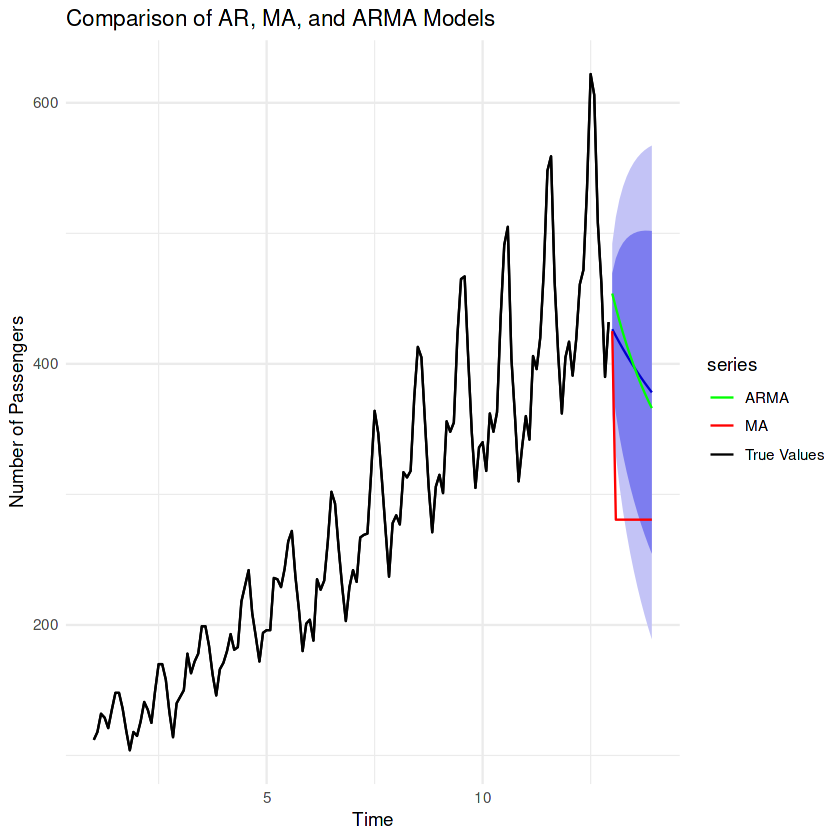

In [129]:
# Your answer here
# AR model (p=1, d=0, q=0)
ar_model <- arima(ts_data, order = c(1, 0, 0))
ar_forecast <- forecast(ar_model, h = 12)

# MA model (p=0, d=0, q=1)
ma_model <- arima(ts_data, order = c(0, 0, 1))
ma_forecast <- forecast(ma_model, h = 12)

# ARMA model (p=1, d=0, q=1)
arma_model <- arima(ts_data, order = c(1, 0, 1))
arma_forecast <- forecast(arma_model, h = 12)

# Plot AR, MA, and ARMA forecasts with original data
autoplot(ar_forecast, series = "AR") +
  autolayer(ts_data, series = "True Values") +
  autolayer(ma_forecast$mean, series = "MA") +
  autolayer(arma_forecast$mean, series = "ARMA") +
  ggtitle("Comparison of AR, MA, and ARMA Models") + 
  ylab("Number of Passengers") + 
  xlab("Time") +
  scale_color_manual(values = c("True Values" = "black", "AR" = "blue", "MA" = "red", "ARMA" = "green")) +
  theme_minimal()


Question 3.11 : Implement the ARIMA model, with the optimal values of p, d, q as calculated from PACF and ACF plots previously. \
Plot the graph between forecasts and true values.

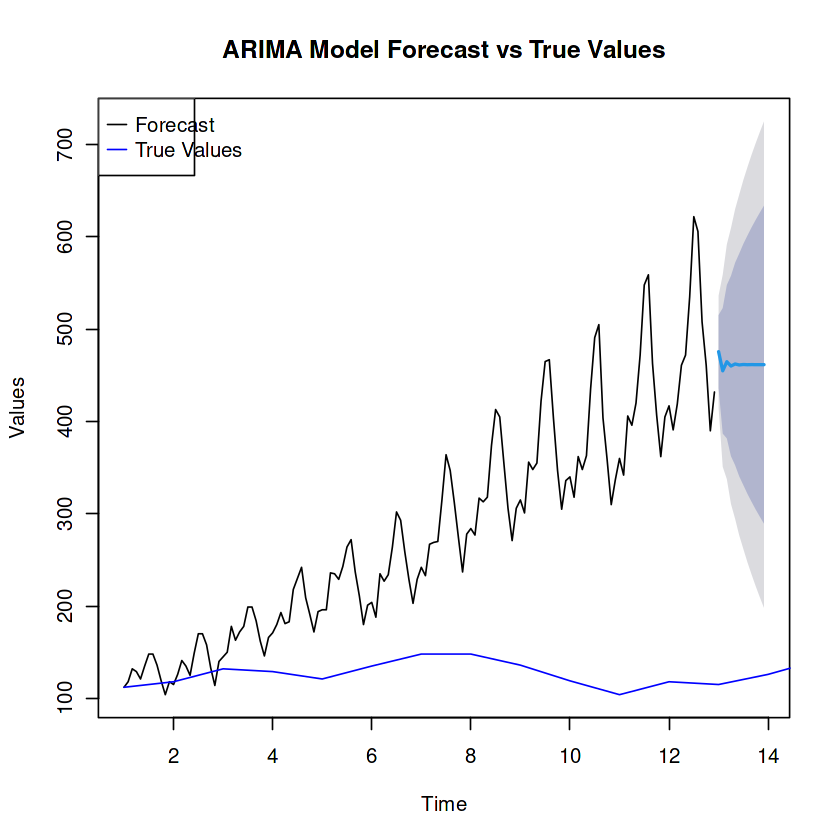

In [133]:
# Your answer here
library(forecast)
optimal_p <- 1
optimal_d <- 1 
optimal_q <- 1 

arima_model <- arima(ts_data, order = c(optimal_p, optimal_d, optimal_q))
n <- 12
arima_forecast <- forecast(arima_model, h = n)
plot(arima_forecast, main = "ARIMA Model Forecast vs True Values", ylab = "Values", xlab = "Time")
lines(df$value, col = 'blue')
legend("topleft", legend = c("Forecast", "True Values"), col = c("black", "blue"), lty = 1)


Question 3.11: 

1. Which models performed better? The exponential smoothing models, or the statistical models (AR, MA, ARMA, ARIMA). Why? 
2. Is this always the case? 
3. Do you think you’d get a better result if you used SARIMA? 

In [134]:
summary(arima_model)


Call:
arima(x = ts_data, order = c(optimal_p, optimal_d, optimal_q))

Coefficients:
          ar1     ma1
      -0.4741  0.8634
s.e.   0.1159  0.0720

sigma^2 estimated as 962.2:  log likelihood = -694.34,  aic = 1394.68

Training set error measures:
                 ME     RMSE      MAE       MPE     MAPE      MASE       ACF1
Training set 1.9209 30.91125 24.12176 0.4150742 8.566115 0.9327776 0.03749257

#### 1. ARIMA Model has lowest MSE, MAE, and RMSE values in comparison to ES. Hence, ARIMA works better here.
#### 2. No, it is NOT always the case that as it varies based on data patterns and characteristics. Exponential smoothing models are generally more effective for data with trends and seasonality, while ARIMA models can be more powerful for stationary data or data that requires differencing.
#### 3. Yes, using SARIMA yields better results if the dataset has seasonal patterns


## SARIMA

Question 3.12: Implement the SARIMA model, with the optimal values of p, d, q as calculated from PACF and ACF plots previously. \
Use Seasonal Order=(2, 1, 0, 12) \
Plot the graph between forecasts and true values.

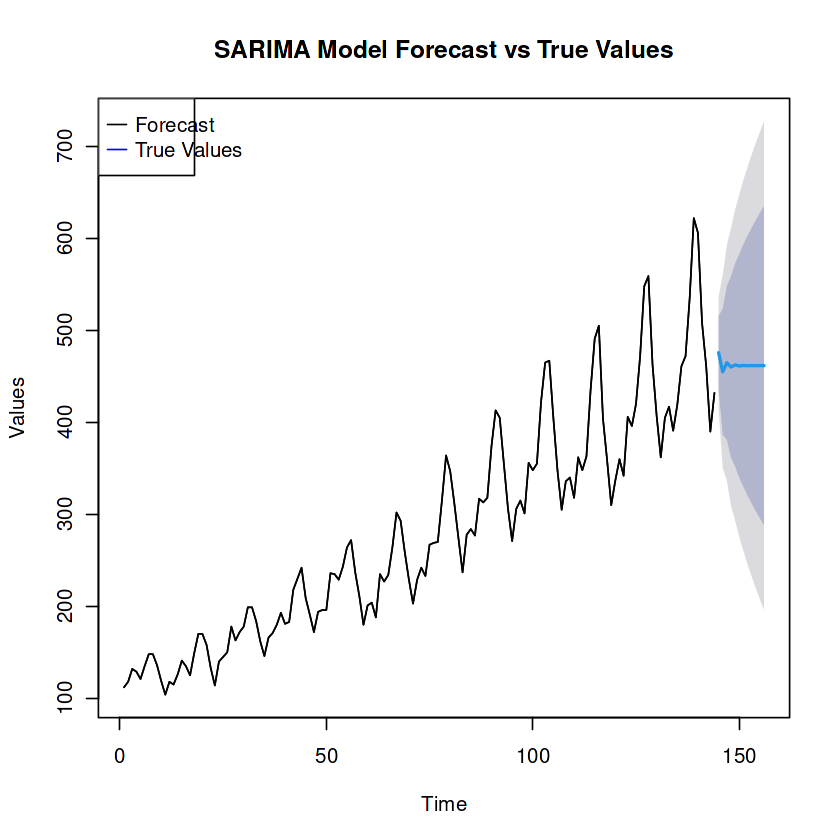

In [136]:
# Your answer here
library(forecast)
seasonal_order <- c(2, 1, 0, 12)
sarima_model <- Arima(df$value, order = c(optimal_p, optimal_d, optimal_q), seasonal = seasonal_order)

sarima_forecast <- forecast(sarima_model, h = n)
plot(sarima_forecast, main = "SARIMA Model Forecast vs True Values", ylab = "Values", xlab = "Time")
lines(df$value)
legend("topleft", legend = c("Forecast", "True Values"), col = c("black", "blue"), lty = 1)


In [137]:
summary(sarima_model)

Series: df$value 
ARIMA(1,1,1) 

Coefficients:
          ar1     ma1
      -0.4741  0.8634
s.e.   0.1159  0.0720

sigma^2 = 975.8:  log likelihood = -694.34
AIC=1394.68   AICc=1394.86   BIC=1403.57

Training set error measures:
                 ME     RMSE      MAE       MPE     MAPE      MASE       ACF1
Training set 1.9209 30.91125 24.12176 0.4150742 8.566115 0.9327776 0.03749257

## Making Predictions

You have implemented multiple forecasting models, including ARIMA, SARIMA, and Exponential Smoothing, now select the **best model** and generate forecasts for the period following the training data, from the end of the training set to the end of the entire dataset.

Replace **selected_model** with the variable name of the best-performing model you have chosen. \
Note: Ensure that selected_model is replaced with the actual model variable you have selected after fitting and evaluating your models. This code will generate and plot forecasts using the chosen model, allowing you to compare them against the actual values from the test dataset.

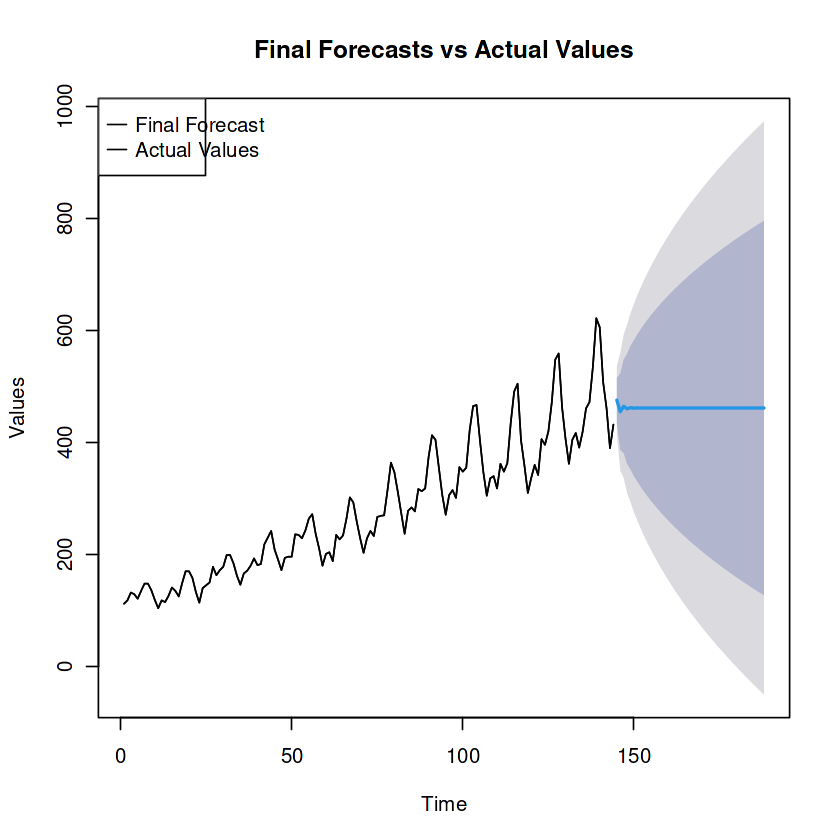

In [138]:
# Your answer here
selected_model <- sarima_model
final_forecast <- forecast(selected_model, h = length(df$value) - train_size)

plot(final_forecast, main = "Final Forecasts vs Actual Values", ylab = "Values", xlab = "Time")
lines(df$value)
legend("topleft", legend = c("Final Forecast", "Actual Values"), lty = 1)


Provide the code for the selected model and then uncomment the following cells one by one to make predictions, forecast, and plot the graphs.

In [139]:
summary(selected_model)

Series: df$value 
ARIMA(1,1,1) 

Coefficients:
          ar1     ma1
      -0.4741  0.8634
s.e.   0.1159  0.0720

sigma^2 = 975.8:  log likelihood = -694.34
AIC=1394.68   AICc=1394.86   BIC=1403.57

Training set error measures:
                 ME     RMSE      MAE       MPE     MAPE      MASE       ACF1
Training set 1.9209 30.91125 24.12176 0.4150742 8.566115 0.9327776 0.03749257

In [140]:
train_prediction <- fitted(selected_model)

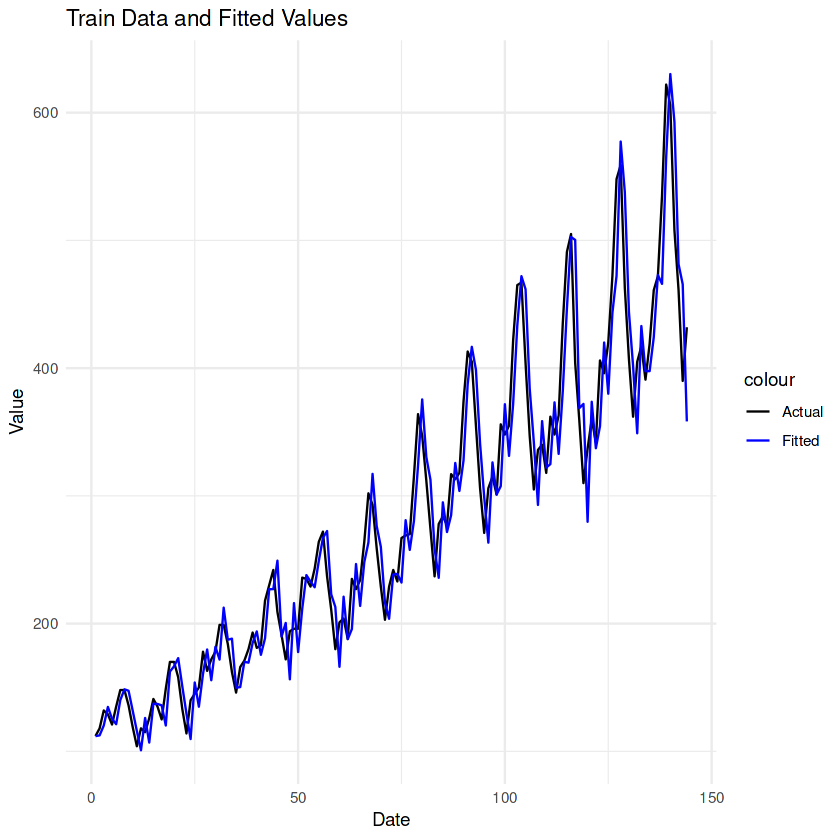

In [141]:
train_ts<-df$value
plot_data <- data.frame(
  Date = time(train_ts),
  Actual = as.numeric(train_ts),
  Fitted = as.numeric(train_prediction)
)

ggplot(plot_data, aes(x = Date)) +
  geom_line(aes(y = Actual, color = "Actual")) +
  geom_line(aes(y = Fitted, color = "Fitted")) +
  labs(title = "Train Data and Fitted Values",
       x = "Date", y = "Value") +
  scale_color_manual(values = c("Actual" = "black", "Fitted" = "blue")) +
  theme_minimal()

In [142]:
df_ts <- ts(df$value, frequency = 12)
df_ts
print(length(train_ts)) 
print(length(df_ts))     


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
1,112,118,132,129,121,135,148,148,136,119,104,118
2,115,126,141,135,125,149,170,170,158,133,114,140
3,145,150,178,163,172,178,199,199,184,162,146,166
4,171,180,193,181,183,218,230,242,209,191,172,194
5,196,196,236,235,229,243,264,272,237,211,180,201
6,204,188,235,227,234,264,302,293,259,229,203,229
7,242,233,267,269,270,315,364,347,312,274,237,278
8,284,277,317,313,318,374,413,405,355,306,271,306
9,315,301,356,348,355,422,465,467,404,347,305,336
10,340,318,362,348,363,435,491,505,404,359,310,337


[1] 144
[1] 144


In [143]:
start_index <- length(train_ts) 
end_index <- length(df_ts)

h <- end_index - start_index + 1
print(h)  # Ensure this is a positive integer


[1] 1


In [145]:
start_index <- length(train_ts)
end_index <- length(df_ts)

prediction <- forecast(sarima_model, h = (end_index - start_index + 1))
prediction_df <- data.frame(prediction = as.numeric(prediction$mean))

prediction_df$Date <- time(df_ts)[start_index:end_index]
print(prediction_df)

  prediction     Date
1   475.7282 12.91667


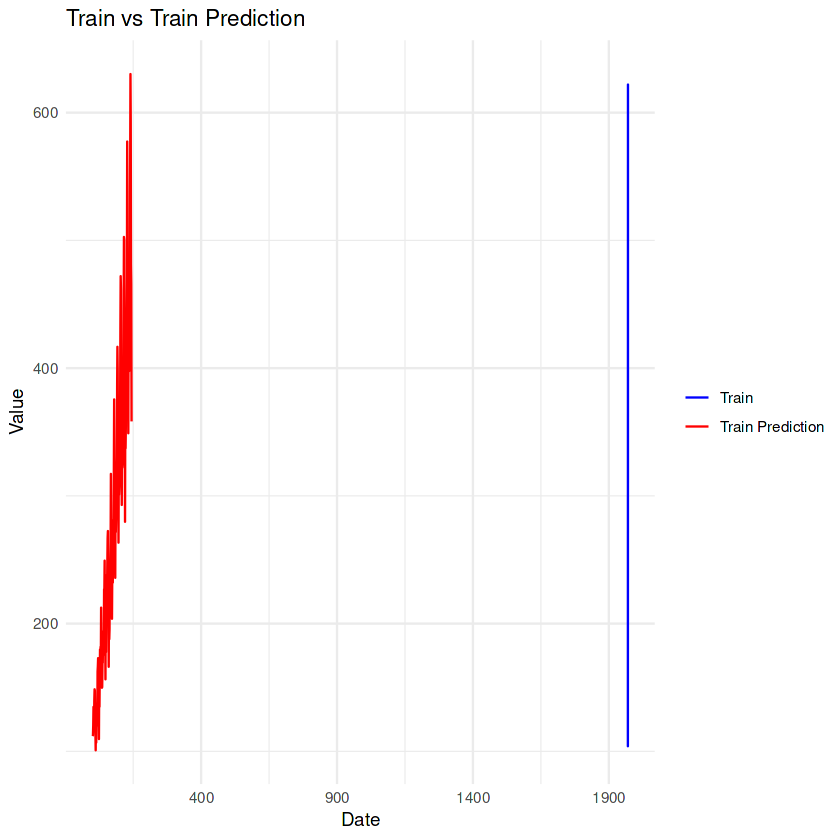

In [146]:
train_df <- data.frame(
  Date = as.Date(time(train_ts), origin = "1970-01-01"),  # Extract time index and convert to Date
  Value = as.numeric(train_ts),  # Convert ts object to numeric values
  Type = "Train"
)

train_prediction_df <- data.frame(
  Date = as.Date(time(train_prediction), origin = "1970-01-01"),  # Extract time index from train_prediction and convert to Date
  Value = as.numeric(train_prediction),  # Convert ts object to numeric values
  Type = "Train Prediction"
)

plot_data <- rbind(train_df, train_prediction_df)

ggplot(plot_data, aes(x = Date, y = Value, color = Type)) +
  geom_line() +
  labs(title = "Train vs Train Prediction",
       x = "Date", y = "Value") +
  scale_color_manual(values = c("Train" = "blue", "Train Prediction" = "red")) +
  theme_minimal() + 
  theme(legend.title = element_blank())

Congratulations on reaching the end of this worksheet! I hope you enjoyed it, and have an understanding of how practical time series analysis works.

Some advanced concepts for you to explore are listed below:

* One of the main errors of dealing with time-series data includes preventing lookahead. It’s extremely
important that you aren’t looking at future values to predict earlier ones. You can read more about it
here: https://bowtiedraptor.substack.com/p/look-ahead-bias-and-how-to-prevent
* Although the dataset provided to you for this worksheet was cleaned prior, real world data is extremely
dirty. Time series data especially tends to contain quite a few missing values. Try to explore some
ways of taking care of missing values in data. Some techniques include imputation, forward fills,
interpolation, moving averages, etc.
* Understanding some Classical Machine Learning techniques for Time Series Forecasting, such as Decision
Trees, Forests, Feed-forward Neural Networks, etc.
https://machinelearningmastery.com/random-forest-for-time-series-forecasting/ \
https://www.section.io/engineering-education/feedforward-and-recurrent-neural-networks-pythonimplementation/